In [1]:
import sys
sys.dont_write_bytecode = True

In [2]:
from foba_backtest_engine.components.order_book.utils.foba_report_enrichments import enrich_foba
from foba_backtest_engine.components.order_book.utils.enums import EventType, Side
from foba_backtest_engine.engine import Engine
from datetime import datetime, time
import numpy as np

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
import foba_backtest_engine.engine as FOBA
from importlib import reload
FOBA = reload(FOBA)

In [4]:
def run_foba_analysis(
    date,
    mode="passive_analysis",
    book_ids=[],
    config=None,
    result_type="dataframe", 
):
    if book_ids is None:
        raise ValueError("need to provide symbols")
    if isinstance(book_ids, str):
        book_ids = [book_ids]

    engine = FOBA.Engine(
        mode=mode,
        book_ids=book_ids,
        date=date,
        config=config,
        result_type=result_type
    )
    engine.run()
    
    return engine

In [5]:
config = {
    'order_insert_path': 'temp_data_2/order_insert.parquet',
    'delete_operation_path': 'temp_data_2/delete_operation.parquet',
    'private_trade_path': 'temp_data_2/private_trade.parquet',
    'private_feed_path': 'temp_data_2/private_feed.parquet',
    'conflated_broker_queue_path': 'temp_data_2/BQ.parquet',
    'order_book_path': 'temp_data_2/book.parquet',
    'fee_info_path': 'temp_data/FeeInfo.feather',
    'tick_schedule_path': 'temp_data/TickSchedule.feather',
    'fee_schedule_path': 'temp_data/FeeSchedule.feather',
    'broker_mapping_path':'temp_data_2/BrokerMapping.parquet'
 }

In [6]:
# date_to_run = datetime.now().date() - dt.timedelta(days = 1)
date_to_run = datetime(2024,9,20).date()

In [7]:
# omdc_foba = run_foba_analysis(
#     date=datetime.combine(date_to_run, time(0,0)),
#     mode="passive_analysis",
#     book_ids=["5"],
#     config=config
# )

### **Inputs**
- book_ids that we have data for/want to analyse
- run-date
- config (no need to specify unless we want to tweak it)

In [8]:
# SYMBOLS = {
#     # 9988: 'ALB',
#     # 700: 'TCH',
#     # 1810: 'MIU',
#     # 2269: 'WXB',
#     # 2318: 'PAI',
#     # 3968: 'CMB',
#     # 981: 'SMC',
#     # 939: 'CCB',
#     # 1398: 'ICB',
#     5: 'HSB',
#     3988: 'BOC'
# }

# run_date = datetime(2024,1,31)

In [9]:
# omdc_foba = run_foba_analysis(
#     date=run_date,
#     mode="passive_analysis",
#     book_ids=list(SYMBOLS.keys()),
#     s3_persist=False
# )

In [10]:
import pandas as pd

from foba_backtest_engine.components.order_book.processors.foba_book_builder import (
    pybuilders,
)
from foba_backtest_engine.components.order_book.processors.foba_extract_foba_events import (
    extract_foba_events,
)
from foba_backtest_engine.components.order_book.utils.enums import Exchange
from foba_backtest_engine.components.order_book.utils.foba_competitor_broker_queue import (
    broker_orders_enrichment,
    competitor_enrichment,
    foreign_counterparty_enrichment,
    omdc_order_number_to_broker_number,
)
from foba_backtest_engine.components.order_book.utils.foba_credit_enricher import (
    event_enricher,
)
from foba_backtest_engine.components.order_book.utils.foba_fee_enrichment import (
    static_data_enrichment,
)
from foba_backtest_engine.components.order_book.utils.foba_feedstates import (
    feed_states_at_join,
    fetch_feed_stats_from_book_builders,
    full_feed_state_enrichment,
)
from foba_backtest_engine.components.order_book.utils.foba_hk_broker_data_fetch import (
    omdc_broker_number_to_name,
)
from foba_backtest_engine.components.order_book.utils.foba_misc_enrichments import (
    category_enrichment,
    derived_enrichment,
)
from foba_backtest_engine.components.order_book.utils.foba_omdc_broker_queue_processor import (
    omdc_broker_queue,
)
from foba_backtest_engine.components.order_book.utils.foba_own_orders import (
    get_optiver_trades,
    optiver_trade_and_quotes,
    order_delete_matches,
    order_deletes,
    order_matches,
    order_numbers_filtered,
    order_state_creates,
)
from foba_backtest_engine.components.order_book.utils.foba_slippages import (
    annotate_slippages,
)
from foba_backtest_engine.components.order_book.utils.foba_static_data_info import (
    static_data_info,
)
from foba_backtest_engine.components.order_book.utils.foba_time import (
    AverageSentTime,
    MaxSentTime,
    MinSentTime,
    TimeProfile,
    omdc_profile,
    send_times,
)
from foba_backtest_engine.enrichment import Enrichment, configure
from foba_backtest_engine.utils.base_utils import ImmutableRecord, get_logger
from foba_backtest_engine.utils.time_utils import start_end_time

In [11]:
conflated_broker_queue_path = config["conflated_broker_queue_path"]
order_book_path=config["order_book_path"]
fee_info_path=config["fee_info_path"]
tick_schedule_path=config["tick_schedule_path"]
fee_schedule_path=config["fee_schedule_path"]
order_insert_path=config["order_insert_path"]
delete_operation_path=config["delete_operation_path"]
private_trade_path=config["private_trade_path"]
private_feed_path=config["private_feed_path"]
broker_mapping_path=config["broker_mapping_path"]

In [12]:
max_workers = config.get("max_workers", 5)
pybuilder_exchange = config.get("pybuilder_exchange", Exchange.OMDC)
currency_rate = config.get("currency_rate", 1.0)
book_ids = ["5"]
date_to_inspect = date_to_run
days_ago = config.get("days_ago", 0)
time_zone = config.get("time_zone", "Asia/Hong_Kong")
end_hour = config.get("end_hour", 16)
end_minute = config.get("end_minute", 1)
exclude_pulls = config.get("exclude_pulls", False)
include_only_optiver_pulls = config.get("include_only_optiver_pulls", True)
exclude_inplace_updates = config.get("exclude_inplace_updates", True)
book_build_parallel = config.get("book_build_parallel", False)

In [13]:
sent_times = config.get(
            "sent_times",
            (
                MinSentTime(omdc_profile),
                MaxSentTime(omdc_profile),
                AverageSentTime(
                    TimeProfile(
                        min_one_way_delay=-float("inf"),
                        min_round_trip_delay=0.36e6,
                        max_one_way_delay=float("inf"),
                        max_round_trip_delay=0.50e6,
                    )
                ),
            ),
        )
annotation_min_change = config.get("annotation_min_change", 0.001)
exclude_lunch = config.get("exclude_lunch", True)
pnl_slippage_times = config.get(
    "pnl_slippage_times",
    [5, 15, 30, 60, 120, 240, 300, 600, 900, 1800, 3600, 7200],
)
bbov_weights = config.get("bbov_weights", [1, 6, 6, 1])
smooth_bbov_alpha = config.get("smooth_bbov_alpha", 0.10)
bbov_interval_s = config.get("bbov_interval_s", 10)
excluded_fee_names = config.get(
    "excluded_fee_names", ["Stock Full Stamp", "Stock Full Stamp - CBBC hedge"]
)
broker_mapping_backup = config.get("broker_mapping_backup", True)

start_time, end_time = start_end_time(
    time_zone=time_zone,
    days_ago=days_ago,
    start_hour=6,
    start_minute=0,
    end_hour=end_hour,
    end_minute=end_minute,
    end_date=date_to_inspect,
)

filter_used = ImmutableRecord(
    start_time=start_time, end_time=end_time, book_ids=book_ids,
    order_insert_path=order_insert_path,
    delete_operation_path=delete_operation_path,
    private_trade_path=private_trade_path, 
    private_feed_path=private_feed_path,
    conflated_broker_queue_path=conflated_broker_queue_path,
    order_book_path = order_book_path,
    fee_info_path = fee_info_path,
    tick_schedule_path = tick_schedule_path,
    fee_schedule_path = fee_schedule_path,
    broker_mapping_path=broker_mapping_path
)


In [14]:
onf = order_numbers_filtered(filter_used)

In [15]:
pybuilds = pybuilders(
    Exchange.OMDC,
    filter_used,
    optiver_order_numbers=onf
)

2024-10-28 05:00:29,035 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Started
2024-10-28 05:00:29,036 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Timerange - 2024-09-20 06:00:00-2024-09-20 16:01:00
2024-10-28 05:00:29,036 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: feed_update_count - 74994
2024-10-28 05:00:31,652 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Percent Complete - 0.1
2024-10-28 05:00:34,781 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Percent Complete - 0.2
2024-10-28 05:00:38,353 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Percent Complete

In [16]:
foba_events = extract_foba_events(
    filter=filter_used,
    pybuilders=pybuilds,
    exclude_pulls=False,
    include_only_optiver_pulls=True,
    exclude_inplace_updates=True
)

In [17]:
sdi = static_data_info(
    filter_used
)

In [18]:
sde = static_data_enrichment(
    foba_events,
    sdi
)

In [19]:
st = send_times(
    foba_events,
    sent_times
)

In [20]:
fs = fetch_feed_stats_from_book_builders(
    pybuilds
)

In [21]:
slippage = annotate_slippages(
    fs,
    pnl_slippage_times,
)

In [22]:
ffse = full_feed_state_enrichment(
    foba_events,
    fs,
    slippage
)

In [23]:
ffsaj = feed_states_at_join(
    foba_events,
    fs,
    slippage
)

In [24]:
osc = order_state_creates(
    filter_used
)

In [25]:
om = order_matches(
    foba_events,
    osc,
    ffsaj
)

In [26]:
od = order_deletes(
    filter_used
)

In [27]:
odm = order_delete_matches(
    foba_events,
    od,
    ffse
)

In [28]:
omd_mapping = omdc_broker_number_to_name(
    filter_used
)

In [29]:
opti_trades = get_optiver_trades(
    filter_used,
    omd_mapping
)

In [ ]:
otq = optiver_trade_and_quotes(
    filter_used,
    foba_events,
    opti_trades,
    odm
)

In [42]:
hits = []
quotes = []

for eventId, event in otq.items():
    if event.optiver_hit:
        hits.append(event)
    elif event.optiver_trade:
        quotes.append(event)
    else:
        pass

In [43]:
len(hits), len(quotes)

(271, 1)

In [31]:
ce = category_enrichment(
    foba_events,
    early_cutoff_time=int(5e6)
)

In [32]:
de = derived_enrichment(
    foba_events,
    st,
    sde,
    time_zone="Asia/Hong_Kong"
)

In [34]:
ee = event_enricher(
    foba_events,
    filter_used,
    fs,
    ffse,
    st,
    sde
)

In [37]:
bq = omdc_broker_queue(
    filter_used,
    foba_events
)

In [39]:
[x.keys() for x in bq["5"]]

[dict_keys(['received_', 'timestampNanos_', 'eeid_event_id', 'securityCode_', 'side_', 'brokerNumber_', 'type', 'broker_queue_msg_index', 'priority_', 'level_', 'createdNanos_']),
 dict_keys(['received_', 'timestampNanos_', 'eeid_event_id', 'securityCode_', 'side_', 'brokerNumber_', 'type', 'broker_queue_msg_index', 'priority_', 'level_', 'createdNanos_']),
 dict_keys(['received_', 'timestampNanos_', 'eeid_event_id', 'securityCode_', 'side_', 'brokerNumber_', 'type', 'broker_queue_msg_index', 'priority_', 'level_', 'createdNanos_']),
 dict_keys(['received_', 'timestampNanos_', 'eeid_event_id', 'securityCode_', 'side_', 'brokerNumber_', 'type', 'broker_queue_msg_index', 'priority_', 'level_', 'createdNanos_']),
 dict_keys(['received_', 'timestampNanos_', 'eeid_event_id', 'securityCode_', 'side_', 'brokerNumber_', 'type', 'broker_queue_msg_index', 'priority_', 'level_', 'createdNanos_']),
 dict_keys(['received_', 'timestampNanos_', 'eeid_event_id', 'securityCode_', 'side_', 'brokerNumber

In [40]:
omdc_order_number_to_broker_number??

Signature: omdc_order_number_to_broker_number(pybuilders, book_ids, omdc_broker_queue)
Docstring: <no docstring>
Source:   
@provides("order_num_to_broker_num")
def omdc_order_number_to_broker_number(pybuilders, book_ids, omdc_broker_queue):
    def items():
        for book, builder in pybuilders.items():
            if book not in [str(x) if isinstance(x, int) else x for x in book_ids]:
                continue
            competitor_matcher = CompetitorMatcher(
                builder.bid_order_queue.order_queue, builder.ask_order_queue.order_queue
            )
            curr_broker_queue = parse_broker_queue_new(omdc_broker_queue[book])
            for snapshot in curr_broker_queue:
                competitor_matcher.match_snapshot(snapshot)
            yield book, competitor_matcher.matched_results

    return ImmutableDict(items())
File:      ~/FobaBacktestEngine/foba_backtest_engine/components/order_book/utils/foba_competitor_broker_queue.py
Type:      function

In [ ]:
omdc_broker_queue

In [ ]:
processors.append(event_enricher)

if enrich_competitor:
    processors.append(omdc_broker_queue)
    processors.append(omdc_order_number_to_broker_number)
    processors.append(competitor_enrichment)
    processors.append(foreign_counterparty_enrichment)
    processors.append(broker_orders_enrichment)


In [52]:
import pandas as pd
omdd = pd.read_parquet("temp_data_2/book.parquet")

In [39]:
FOBA_df = omdc_foba.results

In [48]:
[c for c in FOBA_df.columns if 'comp' in c.lower()]

['competitor_latency',
 'competitor_from_ids',
 'competitor',
 'aggressive_competitor']

In [50]:
FOBA_df["aggressive_competitor"].value_counts()

aggressive_competitor
MKT        7986
Yue Kun       1
Name: count, dtype: int64

In [27]:
enriched_df = enrich_foba(FOBA_df)

In [28]:
trade_data = enriched_df[enriched_df["event_type"]==EventType.TRADE]

In [29]:
trade_data = trade_data.sort_values("createdNanos_").reset_index(drop = True)

In [13]:
trade_data = trade_data.sort_values("createdNanos_").reset_index(drop = True)


trade_data["turnover_original"] = trade_data["turnover"]
trade_data["turnover"] = trade_data["turnover"]/1_000_000

import datetime
from IPython.display import HTML
import IPython.display as iDisp
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

currency_rate = 0.195


In [14]:
end_prices = trade_data.groupby(['date', 'product_symbol'])[['event_price']].last().to_dict()['event_price']

def get_end_price(date, symbol):
    return end_prices[(date, symbol)]

trade_data['currency_rate'] = trade_data['turnover'] / (trade_data['event_volume'] * trade_data['event_price'])
trade_data['eod_price'] = trade_data[['date', 'product_symbol']].apply(lambda x: get_end_price(x['date'], x['product_symbol']), axis=1)

In [15]:
for time in [5,15,30,60,120,240,300,600,900,1800,3600,7200]:
    trade_data[f"passive_pnl_{time}s"] = np.where(trade_data.event_type==EventType.TRADE,
                np.where(trade_data.side==Side.BID, 
                            (trade_data[f"midspot_{time}"]-trade_data.event_price)*(trade_data.event_volume*trade_data.contract_size),
                                (trade_data.event_price-trade_data[f"midspot_{time}"])*(trade_data.event_volume*trade_data.contract_size))-trade_data.fees, 0)
    trade_data[f"aggressive_pnl_{time}s"] = np.where(trade_data.event_type==EventType.TRADE,
                -1*np.where(trade_data.side==Side.BID, 
                            (trade_data[f"midspot_{time}"]-trade_data.event_price)*(trade_data.event_volume*trade_data.contract_size),
                                (trade_data.event_price-trade_data[f"midspot_{time}"])*(trade_data.event_volume*trade_data.contract_size))-trade_data.fees, 0)
    trade_data[f"aggressive_bps_{time}s"] = 10000*(trade_data[f"aggressive_pnl_{time}s"]/(trade_data["event_volume"]*trade_data["event_price"]))
    trade_data[f"passive_bps_{time}s"] = 10000*(trade_data[f"passive_pnl_{time}s"]/(trade_data["event_volume"]*trade_data["event_price"]))

    trade_data[f"aggressive_tick_{time}s"] = (trade_data[f"aggressive_pnl_{time}s"]/(trade_data["event_volume"])/trade_data["tick_size"])
    trade_data[f"passive_tick_{time}s"] = (trade_data[f"passive_pnl_{time}s"]/(trade_data["event_volume"])/trade_data["tick_size"])

In [16]:
trade_data['slipped_pnl_eod'] = np.where(trade_data['side'] == Side.BID, 
                                         (trade_data['eod_price'] - trade_data['event_price']) * trade_data['event_volume'] * trade_data['currency_rate'] - trade_data['fees'], 
                                        (trade_data['event_price'] - trade_data['eod_price']) * trade_data['event_volume'] * trade_data['currency_rate'] - trade_data['fees'])
trade_data['aggressor_slipped_pnl_eod'] = np.where(trade_data['side'] == Side.BID, 
                                                   (trade_data['event_price'] - trade_data['eod_price']) * trade_data['event_volume'] * trade_data['currency_rate'] - trade_data['fees'], 
                                                   (trade_data['eod_price'] - trade_data['event_price']) * trade_data['event_volume'] * trade_data['currency_rate'] - trade_data['fees'])

In [17]:
pnl_fields = [f"passive_pnl_{x}s" for x in [5, 15, 30, 60, 120, 240, 300, 600, 900, 1800, 3600, 7200]] + \
             [f"aggressive_pnl_{x}s" for x in [5, 15, 30, 60, 120, 240, 300, 600, 900, 1800, 3600, 7200]] + ["slipped_pnl_eod", "aggressor_slipped_pnl_eod"]
currency_rate = 0.195
trade_data[pnl_fields] = trade_data[pnl_fields] * currency_rate

In [33]:
# Converting the turnover to mHKD
trade_data["turnover_original"] = trade_data["turnover"]
trade_data["turnover"] = trade_data["turnover"]/1_000_000


In [34]:
import datetime
from IPython.display import HTML
import IPython.display as iDisp
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [35]:
currency_rate = 0.195

In [36]:
total_turnover = trade_data["turnover_original"].sum()
trade_data["buy_turnover"] = np.where(trade_data["side"] == Side.BID, trade_data["turnover_original"], 0)
trade_data["sell_turnover"] = np.where(trade_data["side"] == Side.ASK, trade_data["turnover_original"], 0)
grouped = trade_data.groupby("broker_name").agg({
    "passive_pnl_30s":"sum",
    "passive_pnl_60s":"sum",
    "passive_pnl_120s":"sum",
    "passive_pnl_300s":"sum",
    "passive_pnl_900s":"sum",
    "slipped_pnl_eod":"sum",
    "turnover_original":"sum",
    "buy_turnover":"sum",
    "sell_turnover":"sum"
})
grouped["mkt%"] = 100*grouped["turnover_original"]/total_turnover
grouped["bps_pnl_120s"] = 10_000*grouped["passive_pnl_120s"]/(grouped["turnover_original"]*currency_rate)
grouped["bps_pnl_300s"] = 10_000*grouped["passive_pnl_300s"]/(grouped["turnover_original"]*currency_rate)
grouped["turnover_original"] = grouped["turnover_original"]/1_000_000
grouped["buy_turnover"] = grouped["buy_turnover"]/1_000_000
grouped["sell_turnover"] = grouped["sell_turnover"]/1_000_000

In [38]:
iDisp.display(HTML("<H3>by Broker Name</H3>"))
styled = grouped.sort_values("slipped_pnl_eod", ascending=True).head(7).style \
    .background_gradient(subset=["mkt%"], cmap="Reds", low=0, high=1) \
    .background_gradient(subset=["passive_pnl_30s", "passive_pnl_60s", "passive_pnl_120s", "passive_pnl_300s", "passive_pnl_900s", "slipped_pnl_eod"], cmap="Greens", low=0, high=1) \
    .background_gradient(subset=["bps_pnl_120s", "bps_pnl_300s"], cmap="Blues", low=6, high=10) \
    .background_gradient(subset=["turnover_original", "buy_turnover", "sell_turnover"], cmap="Blues", low=0, high=1)
styled


,passive_pnl_30s,passive_pnl_60s,passive_pnl_120s,passive_pnl_300s,passive_pnl_900s,slipped_pnl_eod,turnover_original,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_300s
broker_name,,,,,,,,,,,,
Merrill Lynch Far East Limited,-4064.791630,-8974.891630,-5556.541630,-10425.691630,420.208370,-80631.541630,243.008160,232.503840,10.504320,13.586549,-1.172598,-2.200135
IMC Asia Pacific Limited,-898.640539,-4235.090539,-4769.390539,-6461.990539,-7175.690539,-45623.840539,154.536940,116.525540,38.011400,8.640137,-1.582690,-2.144368
Barclays Capital Asia Limited,-1614.045560,-1227.945560,4074.104440,-3119.445560,-3088.245560,-42517.245560,164.865840,126.804160,38.061680,9.217624,1.267263,-0.970314
ABN AMRO Clearing Hong Kong Limited,-2633.716753,-3179.716753,-1336.966753,-4642.216753,-4367.266753,-34020.916753,188.768720,135.886880,52.881840,10.554030,-0.363208,-1.261133
China Investment Information Services Limited,-4899.323005,-1699.373005,-3491.423005,-4922.723005,-7951.073005,-13929.773005,87.967920,48.280120,39.687800,4.918273,-2.035371,-2.869766
J.P. Morgan Broking (Hong Kong) Limited,-3017.535682,-665.835682,-74.985682,3353.114318,1124.264318,-8136.285682,55.222120,41.203160,14.018960,3.087460,-0.069635,3.113871
CLSA Limited,101.112547,-961.637453,-1406.237453,-1248.287453,-852.437453,-5085.887453,29.033640,25.299360,3.734280,1.623266,-2.483834,-2.204847


In [42]:
total_turnover = trade_data["turnover_original"].sum()
trade_data["buy_turnover"] = np.where(trade_data["side"] == Side.BID, trade_data["turnover_original"], 0)
trade_data["sell_turnover"] = np.where(trade_data["side"] == Side.ASK, trade_data["turnover_original"], 0)
grouped = trade_data.groupby("competitor").agg({
    "passive_pnl_30s":"sum",
    "passive_pnl_60s":"sum",
    "passive_pnl_120s":"sum",
    "passive_pnl_300s":"sum",
    "passive_pnl_900s":"sum",
    "slipped_pnl_eod":"sum",
    "turnover_original":"sum",
    "buy_turnover":"sum",
    "sell_turnover":"sum"
})
grouped["mkt%"] = 100*grouped["turnover_original"]/total_turnover
grouped["bps_pnl_120s"] = 10_000*grouped["passive_pnl_120s"]/(grouped["turnover_original"]*currency_rate)
grouped["bps_pnl_300s"] = 10_000*grouped["passive_pnl_300s"]/(grouped["turnover_original"]*currency_rate)
grouped["turnover_original"] = grouped["turnover_original"]/1_000_000
grouped["buy_turnover"] = grouped["buy_turnover"]/1_000_000
grouped["sell_turnover"] = grouped["sell_turnover"]/1_000_000

In [43]:
iDisp.display(HTML("<H3>by Known Competitor Name</H3>"))
styled = grouped.sort_values("passive_pnl_120s", ascending=False).head(7).style \
    .background_gradient(subset=["mkt%"], cmap="Reds", low=0, high=1) \
    .background_gradient(subset=["passive_pnl_30s", "passive_pnl_60s", "passive_pnl_120s", "passive_pnl_300s", "passive_pnl_900s", "slipped_pnl_eod"], cmap="Greens", low=0, high=1) \
    .background_gradient(subset=["bps_pnl_120s", "bps_pnl_300s"], cmap="Blues", low=6, high=10) \
    .background_gradient(subset=["turnover_original", "buy_turnover", "sell_turnover"], cmap="Blues", low=0, high=1)
styled

,passive_pnl_30s,passive_pnl_60s,passive_pnl_120s,passive_pnl_300s,passive_pnl_900s,slipped_pnl_eod,turnover_original,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_300s
competitor,,,,,,,,,,,,
Optiver,12989.579093,12846.254093,10418.504093,20372.279093,20762.279093,38617.454093,143.622360,61.344330,82.278030,13.136363,3.720049,7.274162
IMC,2679.087337,5871.237337,3989.487337,6243.687337,6426.987337,-1849.787663,59.632260,38.244450,21.387810,5.454242,3.430846,5.369394
Yue Kun,1357.905266,3128.505266,2744.355266,3237.705266,2366.055266,-769.544734,15.950250,8.704820,7.245430,1.458883,8.823446,10.409628
Eclipse,187.153276,649.303276,380.203276,3681.553276,3642.553276,7419.703276,43.949170,23.913670,20.035500,4.019794,0.443640,4.295817
Jump Trading,-11.844618,21.305382,21.305382,-46.944618,-46.944618,-8.919618,0.419110,0.000000,0.419110,0.038334,2.606914,-5.744116
JP,144.276163,144.276163,-167.723837,144.276163,768.276163,612.276163,2.745280,0.000000,2.745280,0.251096,-3.133095,2.695090
Barclays,-1730.983490,-1851.883490,-2171.683490,-1703.683490,-4078.783490,4399.816510,31.592770,18.138010,13.454760,2.889620,-3.525122,-2.765455


In [18]:
total_turnover = trade_data["turnover_original"].sum()
trade_data["buy_turnover"] = np.where(trade_data["side"] == Side.BID, trade_data["turnover_original"], 0)
trade_data["sell_turnover"] = np.where(trade_data["side"] == Side.ASK, trade_data["turnover_original"], 0)
grouped = trade_data.groupby("competitor").agg({
    "passive_pnl_30s":"sum",
    "passive_pnl_60s":"sum",
    "passive_pnl_120s":"sum",
    "passive_pnl_300s":"sum",
    "passive_pnl_900s":"sum",
    "slipped_pnl_eod":"sum",
    "turnover_original":"sum",
    "buy_turnover":"sum",
    "sell_turnover":"sum"
})
grouped["mkt%"] = 100*grouped["turnover_original"]/total_turnover
grouped["bps_pnl_120s"] = 10_000*grouped["passive_pnl_120s"]/(grouped["turnover_original"]*currency_rate)
grouped["bps_pnl_300s"] = 10_000*grouped["passive_pnl_300s"]/(grouped["turnover_original"]*currency_rate)
grouped["turnover_original"] = grouped["turnover_original"]/1_000_000
grouped["buy_turnover"] = grouped["buy_turnover"]/1_000_000
grouped["sell_turnover"] = grouped["sell_turnover"]/1_000_000

In [19]:
iDisp.display(HTML("<H3>by Known Competitor Name</H3>"))
styled = grouped.sort_values("passive_pnl_120s", ascending=False).head(7).style \
    .background_gradient(subset=["mkt%"], cmap="Reds", low=0, high=1) \
    .background_gradient(subset=["passive_pnl_30s", "passive_pnl_60s", "passive_pnl_120s", "passive_pnl_300s", "passive_pnl_900s", "slipped_pnl_eod"], cmap="Greens", low=0, high=1) \
    .background_gradient(subset=["bps_pnl_120s", "bps_pnl_300s"], cmap="Blues", low=6, high=10) \
    .background_gradient(subset=["turnover_original", "buy_turnover", "sell_turnover"], cmap="Blues", low=0, high=1)
styled

,passive_pnl_30s,passive_pnl_60s,passive_pnl_120s,passive_pnl_300s,passive_pnl_900s,slipped_pnl_eod,turnover_original,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_300s
competitor,,,,,,,,,,,,
ABN,60836.803144,61545.530644,55496.825644,77321.518144,130436.495644,427424.420644,1336.860732,634.130730,702.730002,8.555245,2.128861,2.966058
IMC,31005.024124,37586.566624,32034.721624,32009.469124,47410.666624,69877.591624,682.317751,362.868270,319.449481,4.366495,2.407685,2.405787
Yue Kun,4213.759606,6997.579606,5798.914606,4812.897106,-2759.635394,2140.324606,61.547006,31.371214,30.175792,0.393870,4.831758,4.010191
UBS,2454.840310,3346.965310,4499.415310,6678.150310,11515.222810,5237.977810,13.605604,9.058430,4.547174,0.087069,16.959133,25.171190
Jump Trading,615.977064,1412.357064,343.172064,-878.990436,-2879.202936,-5563.475436,7.890967,3.987553,3.903414,0.050498,2.230217,-5.712409
Citadel,40.458825,-27.791175,147.708825,84.333825,225.708825,274.458825,0.194650,0.162000,0.032650,0.001246,38.915035,22.218400
JP,-986.302466,-698.482466,-838.882466,4313.407534,8599.897534,20910.247534,13.087020,0.000000,13.087020,0.083750,-3.287197,16.902273


In [20]:
total_turnover = trade_data["turnover_original"].sum()
trade_data["buy_turnover"] = np.where(trade_data["side"] == Side.BID, trade_data["turnover_original"], 0)
trade_data["sell_turnover"] = np.where(trade_data["side"] == Side.ASK, trade_data["turnover_original"], 0)
grouped = trade_data.groupby("broker_number").agg({
    "passive_pnl_30s":"sum",
    "passive_pnl_60s":"sum",
    "passive_pnl_120s":"sum",
    "passive_pnl_300s":"sum",
    "passive_pnl_900s":"sum",
    "slipped_pnl_eod":"sum",
    "turnover_original":"sum",
    "buy_turnover":"sum",
    "sell_turnover":"sum"
})
grouped["mkt%"] = 100*grouped["turnover_original"]/total_turnover
grouped["bps_pnl_120s"] = 10_000*grouped["passive_pnl_120s"]/(grouped["turnover_original"]*currency_rate)
grouped["bps_pnl_300s"] = 10_000*grouped["passive_pnl_300s"]/(grouped["turnover_original"]*currency_rate)
grouped["turnover_original"] = grouped["turnover_original"]/1_000_000
grouped["buy_turnover"] = grouped["buy_turnover"]/1_000_000
grouped["sell_turnover"] = grouped["sell_turnover"]/1_000_000

In [22]:
iDisp.display(HTML("<H3>by Broker Code, sorted by 120s absolute return</H3>"))
styled = grouped.sort_values("passive_pnl_120s", ascending=False).head(7).style \
    .background_gradient(subset=["mkt%"], cmap="Reds", low=0, high=1) \
    .background_gradient(subset=["passive_pnl_30s", "passive_pnl_60s", "passive_pnl_120s", "passive_pnl_300s", "passive_pnl_900s", "slipped_pnl_eod"], cmap="Greens", low=0, high=1) \
    .background_gradient(subset=["bps_pnl_120s", "bps_pnl_300s"], cmap="Blues", low=6, high=10) \
    .background_gradient(subset=["turnover_original", "buy_turnover", "sell_turnover"], cmap="Blues", low=0, high=1)
styled

,passive_pnl_30s,passive_pnl_60s,passive_pnl_120s,passive_pnl_300s,passive_pnl_900s,slipped_pnl_eod,turnover_original,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_300s
broker_number,,,,,,,,,,,,
1477,19056.986095,20944.586095,20212.361095,7626.086095,19273.436095,32731.361095,143.454600,45.050500,98.404100,0.918038,7.225501,2.726168
8445,8975.248666,11057.751166,13461.711166,20421.456166,17147.698666,50465.496166,139.179952,57.478284,81.701668,0.890683,4.960083,7.524461
8443,8274.622626,9669.750126,11114.115126,16323.637626,21513.270126,45015.060126,122.191926,55.538692,66.653234,0.781968,4.664421,6.850777
1496,7898.903300,12409.253300,10636.703300,10558.703300,-1277.796700,27183.428300,84.612300,32.976760,51.635540,0.541477,6.446722,6.399447
1475,12172.181384,11930.381384,8194.181384,10867.631384,16243.781384,40120.556384,136.345790,60.565520,75.780270,0.872545,3.081976,4.087507
8565,8077.162227,8947.349727,6718.889727,10874.632227,25765.319727,71962.379727,142.101056,62.382875,79.718181,0.909376,2.424742,3.924485
8564,8329.409119,5609.646619,6625.499119,2158.341619,24893.391619,50050.146619,123.371221,65.306534,58.064687,0.789515,2.754039,0.897164


In [23]:
iDisp.display(HTML("<H3>by Broker Code, sorted by 120s bps return</H3>"))
styled = grouped.sort_values("bps_pnl_120s", ascending=False).head(7).style \
    .background_gradient(subset=["mkt%"], cmap="Reds", low=0, high=1) \
    .background_gradient(subset=["passive_pnl_30s", "passive_pnl_60s", "passive_pnl_120s", "passive_pnl_300s", "passive_pnl_900s", "slipped_pnl_eod"], cmap="Greens", low=0, high=1) \
    .background_gradient(subset=["bps_pnl_120s", "bps_pnl_300s"], cmap="Blues", low=6, high=10) \
    .background_gradient(subset=["turnover_original", "buy_turnover", "sell_turnover"], cmap="Blues", low=0, high=1)
styled

,passive_pnl_30s,passive_pnl_60s,passive_pnl_120s,passive_pnl_300s,passive_pnl_900s,slipped_pnl_eod,turnover_original,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_300s
broker_number,,,,,,,,,,,,
6474,62.374921,62.374921,52.624921,23.374921,-54.625079,-254.500079,0.021700,0.021700,0.000000,0.000139,124.364696,55.240272
1166,84.359420,129.209420,205.259420,335.909420,64.859420,-330.015580,0.100270,0.100270,0.000000,0.000642,104.977801,171.797388
3235,88.543085,137.293084,332.293085,527.293085,-57.706916,-1763.956916,0.213000,0.213000,0.000000,0.001363,80.003150,126.951507
6800,54.983514,93.983514,93.983514,93.983514,93.983514,-120.516486,0.082200,0.082200,0.000000,0.000526,58.633423,58.633423
6476,56.553914,56.553914,46.803914,17.553914,-60.446086,-255.446086,0.042100,0.021700,0.020400,0.000269,57.011893,21.382439
2429,84.860031,148.040031,209.660031,22.460031,209.660031,1925.660031,0.205440,0.000000,0.205440,0.001315,52.335458,5.606486
3537,17.539353,-31.210647,163.789353,115.039353,212.539353,285.664353,0.162000,0.162000,0.000000,0.001037,51.848481,36.416383


In [24]:
from foba_backtest_engine.maintained_configs.HKEX_symbol_map import HK_STOCK_DICT

In [25]:
trade_data["sector"] = trade_data["product_symbol"].apply(lambda x:HK_STOCK_DICT[x].sector)

In [26]:
iDisp.display(HTML("<H3> PNL by number of ticks wide at event </H3>"))
a = trade_data[trade_data.broker_name.isin(['ABN AMRO Clearing Hong Kong Limited',"IMC Asia Pacific Limited", "Optiver Trading Hong Kong Limited"])].groupby(['broker_name','ticks_wide_at_event_bucket'])[
    ['turnover_original', 'passive_pnl_120s','passive_pnl_300s', 'passive_pnl_600s']].sum()

a['bps_120s'] = 10000 * a['passive_pnl_120s'] / (a['turnover_original'] * currency_rate) 
a['bps_300s'] = 10000 * a['passive_pnl_300s'] /(a['turnover_original'] * currency_rate) 
a['bps_600s'] = 10000 * a['passive_pnl_600s'] / (a['turnover_original'] * currency_rate) 
a

turnover_original  \
broker_name                         ticks_wide_at_event_bucket                      
ABN AMRO Clearing Hong Kong Limited 1                                1.256358e+09   
                                    2                                8.007852e+07   
                                    3+                               4.241100e+05   
IMC Asia Pacific Limited            1                                6.150157e+08   
                                    2                                6.688513e+07   
                                    3+                               4.168800e+05   
Optiver Trading Hong Kong Limited   1                                5.482610e+08   
                                    2                                2.769000e+05   

                                                                passive_pnl_120s  \
broker_name                         ticks_wide_at_event_bucket                     
ABN AMRO Clearing Hong Kong Limited 1                               41097.481660   
                                    2                               14213.794203   
                                    3+                                185.549781   
IMC Asia Pacific Limited            1                               27866.892901   
                                    2                                4092.153221   
                                    3+                                 75.675502   
Optiver Trading Hong Kong Limited   1                               41860.146933   
                                    2                                 127.712760   

                                                                passive_pnl_300s  \
broker_name                         ticks_wide_at_event_bucket                     
ABN AMRO Clearing Hong Kong Limited 1                               57151.441660   
                                    2                               19821.701703   
                                    3+                                348.374781   
IMC Asia Pacific Limited            1                               23814.792901   
                                    2                                8161.900721   
                                    3+                                 32.775502   
Optiver Trading Hong Kong Limited   1                               37152.846933   
                                    2                                 -64.362240   

                                                                passive_pnl_600s  \
broker_name                         ticks_wide_at_event_bucket                     
ABN AMRO Clearing Hong Kong Limited 1                               81458.289160   
                                    2                               28625.171703   
                                    3+                                626.249781   
IMC Asia Pacific Limited            1                               45383.645401   
                                    2                               10080.993221   
                                    3+                                 65.438002   
Optiver Trading Hong Kong Limited   1                               44422.446933   
                                    2                                 -74.112240   

                                                                 bps_120s  \
broker_name                         ticks_wide_at_event_bucket              
ABN AMRO Clearing Hong Kong Limited 1                            1.677518   
                                    2                            9.102473   
                                    3+                          22.436098   
IMC Asia Pacific Limited            1                            2.323634   
                                    2                            3.137529   
                                    3+                           9.309142   
Optiver Trading Hong Kong Limited   1                            3.915424 

In [27]:
iDisp.display(HTML("<H3> PNL by number of ticks wide at join </H3>"))
a = trade_data[trade_data.broker_name.isin(['ABN AMRO Clearing Hong Kong Limited',"IMC Asia Pacific Limited", "Optiver Trading Hong Kong Limited"])].groupby(['broker_name','ticks_wide_at_join_bucket'])[
    ['turnover_original', 'passive_pnl_120s','passive_pnl_300s', 'passive_pnl_600s']].sum()

a['bps_120s'] = 10000 * a['passive_pnl_120s'] / (a['turnover_original'] * currency_rate) 
a['bps_300s'] = 10000 * a['passive_pnl_300s'] /(a['turnover_original'] * currency_rate) 
a['bps_600s'] = 10000 * a['passive_pnl_600s'] / (a['turnover_original'] * currency_rate) 
a

turnover_original  \
broker_name                         ticks_wide_at_join_bucket                      
ABN AMRO Clearing Hong Kong Limited 0                               6.112000e+05   
                                    1                               1.201599e+09   
                                    2                               1.318909e+08   
                                    3+                              2.759245e+06   
IMC Asia Pacific Limited            1                               5.767512e+08   
                                    2                               1.039200e+08   
                                    3+                              1.646565e+06   
Optiver Trading Hong Kong Limited   0                               9.130600e+05   
                                    1                               4.875445e+08   
                                    2                               6.008041e+07   

                                                               passive_pnl_120s  \
broker_name                         ticks_wide_at_join_bucket                     
ABN AMRO Clearing Hong Kong Limited 0                                130.285553   
                                    1                              42899.774524   
                                    2                              11173.047223   
                                    3+                              1293.718343   
IMC Asia Pacific Limited            1                              19673.251005   
                                    2                              12070.767020   
                                    3+                               290.703599   
Optiver Trading Hong Kong Limited   0                                -38.074861   
                                    1                              29927.969087   
                                    2                              12097.965467   

                                                               passive_pnl_300s  \
broker_name                         ticks_wide_at_join_bucket                     
ABN AMRO Clearing Hong Kong Limited 0                                128.335553   
                                    1                              65503.004524   
                                    2                               9082.159723   
                                    3+                              2608.018343   
IMC Asia Pacific Limited            1                              15151.591005   
                                    2                              16512.087020   
                                    3+                               345.791099   
Optiver Trading Hong Kong Limited   0                                -38.074861   
                                    1                              24691.244087   
                                    2                              12435.315467   

                                                               passive_pnl_600s  \
broker_name                         ticks_wide_at_join_bucket                     
ABN AMRO Clearing Hong Kong Limited 0                                130.285553   
                                    1                              93005.512024   
                                    2                              13929.469723   
                                    3+                              3644.443343   
IMC Asia Pacific Limited            1                              38880.068505   
                                    2                              16441.692020   
                                    3+                               208.316099   
Optiver Trading Hong Kong Limited   0                               -730.324861   
                                    1                              30761.594087   
                                    2                              14317.065467   

                                                               

In [29]:
from foba_backtest_engine.components.order_book.utils.foba_misc_enrichments import JoinType

In [30]:
trade_data["join_type"] = np.where(trade_data.join_type == JoinType.DIME, "DIME", 
                                   np.where(trade_data.join_type == JoinType.JOIN, "JOIN",
                                            np.where(trade_data.join_type == JoinType.DEEPER_JOIN, "DEEPER_JOIN", "CROSS")))

In [31]:
iDisp.display(HTML("<H3> PNL by join type </H3>"))
a = trade_data[trade_data.broker_name.isin(['ABN AMRO Clearing Hong Kong Limited',"IMC Asia Pacific Limited", "Optiver Trading Hong Kong Limited"])].groupby(['broker_name','join_type'])[
    ['turnover_original', 'passive_pnl_120s','passive_pnl_300s', 'passive_pnl_600s']].sum()

a['bps_120s'] = 10000 * a['passive_pnl_120s'] / (a['turnover_original'] * currency_rate) 
a['bps_300s'] = 10000 * a['passive_pnl_300s'] /(a['turnover_original'] * currency_rate) 
a['bps_600s'] = 10000 * a['passive_pnl_600s'] / (a['turnover_original'] * currency_rate) 
a

turnover_original  \
broker_name                         join_type                        
ABN AMRO Clearing Hong Kong Limited CROSS             4.633327e+06   
                                    DEEPER_JOIN       6.122821e+07   
                                    DIME              5.963819e+07   
                                    JOIN              1.211361e+09   
IMC Asia Pacific Limited            CROSS             4.574560e+06   
                                    DEEPER_JOIN       6.127802e+07   
                                    DIME              6.760089e+07   
                                    JOIN              5.488643e+08   
Optiver Trading Hong Kong Limited   DEEPER_JOIN       3.934386e+07   
                                    DIME              6.713528e+07   
                                    JOIN              4.420588e+08   

                                                 passive_pnl_120s  \
broker_name                         join_type                       
ABN AMRO Clearing Hong Kong Limited CROSS             -799.458787   
                                    DEEPER_JOIN      -2395.667969   
                                    DIME              3888.431527   
                                    JOIN             54803.520872   
IMC Asia Pacific Limited            CROSS              -53.576961   
                                    DEEPER_JOIN       4270.285175   
                                    DIME              6885.884715   
                                    JOIN             20932.128695   
Optiver Trading Hong Kong Limited   DEEPER_JOIN      -1704.308841   
                                    DIME              9991.711231   
                                    JOIN             33700.457302   

                                                 passive_pnl_300s  \
broker_name                         join_type                       
ABN AMRO Clearing Hong Kong Limited CROSS             -660.423787   
                                    DEEPER_JOIN       -658.412969   
                                    DIME              2391.709027   
                                    JOIN             76248.645872   
IMC Asia Pacific Limited            CROSS             -221.276961   
                                    DEEPER_JOIN       2801.350175   
                                    DIME              8992.957215   
                                    JOIN             20436.438695   
Optiver Trading Hong Kong Limited   DEEPER_JOIN       1967.541159   
                                    DIME              8667.661231   
                                    JOIN             26453.282302   

                                                 passive_pnl_600s  bps_120s  \
broker_name                         join_type                                 
ABN AMRO Clearing Hong Kong Limited CROSS             -680.313787 -8.848477   
                                    DEEPER_JOIN      -6010.480469 -2.006506   
                                    DIME                 6.859027  3.343608   
                                    JOIN            117393.645872  2.320066   
IMC Asia Pacific Limited            CROSS              976.998039 -0.600612   
                                    DEEPER_JOIN       1550.717675  3.573695   
                                    DIME             11797.934715  5.223633   
                                    JOIN             41204.426195  1.955752   
Optiver Trading Hong Kong Limited   DEEPER_JOIN       2158.641159 -2.221451   
                                    DIME              8416.111231  7.632283   
                                    JOIN             33773.582302  3.909499   

                                                 bps_300s   bps_600s  
broker_name                         join_type                         
ABN AMRO Clearing Hong Kong Limited CROSS       -7.309626  -7.529770  
                                    DEEPER_JOIN -0.551458  -5.034114  
                              

## **PRIORITY ANALYSIS/CONFIG**

In [32]:
iDisp.display(HTML("<H3> PNL by volume ahead factor </H3>"))
a = trade_data[trade_data.broker_name.isin(['ABN AMRO Clearing Hong Kong Limited',"IMC Asia Pacific Limited", "Optiver Trading Hong Kong Limited"])].groupby(['broker_name','volume_ahead_factor_bucket'])[
    ['turnover_original', 'passive_pnl_120s','passive_pnl_300s', 'passive_pnl_600s']].sum()

a['bps_120s'] = 10000 * a['passive_pnl_120s'] / (a['turnover_original'] * currency_rate) 
a['bps_300s'] = 10000 * a['passive_pnl_300s'] /(a['turnover_original'] * currency_rate) 
a['bps_600s'] = 10000 * a['passive_pnl_600s'] / (a['turnover_original'] * currency_rate) 
a

turnover_original  \
broker_name                         volume_ahead_factor_bucket                      
ABN AMRO Clearing Hong Kong Limited 0.0-0.5                           191440461.0   
                                    0.5-2.0                           263359609.0   
                                    2.0-5.0                           294580610.0   
                                    5.0+                              587480052.0   
IMC Asia Pacific Limited            0.0-0.5                           108751865.0   
                                    0.5-2.0                           112710673.0   
                                    2.0-5.0                           223627028.0   
                                    5.0+                              237228185.0   
Optiver Trading Hong Kong Limited   0.0-0.5                           183584710.0   
                                    0.5-2.0                           135748640.0   
                                    2.0-5.0                           114616630.0   
                                    5.0+                              114587960.0   

                                                                passive_pnl_120s  \
broker_name                         volume_ahead_factor_bucket                     
ABN AMRO Clearing Hong Kong Limited 0.0-0.5                         15448.338685   
                                    0.5-2.0                         16098.107103   
                                    2.0-5.0                         10905.853898   
                                    5.0+                            13044.525957   
IMC Asia Pacific Limited            0.0-0.5                          7025.016803   
                                    0.5-2.0                          2731.913623   
                                    2.0-5.0                         11996.371711   
                                    5.0+                            10281.419487   
Optiver Trading Hong Kong Limited   0.0-0.5                         25950.869365   
                                    0.5-2.0                          9296.491442   
                                    2.0-5.0                         -4592.586800   
                                    5.0+                            11333.085686   

                                                                passive_pnl_300s  \
broker_name                         volume_ahead_factor_bucket                     
ABN AMRO Clearing Hong Kong Limited 0.0-0.5                         29312.156185   
                                    0.5-2.0                         22504.734603   
                                    2.0-5.0                          7238.098898   
                                    5.0+                            18266.528457   
IMC Asia Pacific Limited            0.0-0.5                          9598.919303   
                                    0.5-2.0                          -354.253877   
                                    2.0-5.0                         13290.586711   
                                    5.0+                             9474.216987   
Optiver Trading Hong Kong Limited   0.0-0.5                         23293.994365   
                                    0.5-2.0                          7992.916442   
                                    2.0-5.0                          2677.988200   
                                    5.0+                             3123.585686   

                                                                passive_pnl_600s  \
broker_name                         volume_ahead_factor_bucket                     
ABN AMRO Clearing Hong Kong Limited 0.0-0.5                         32048.298685   
                                    0.5-2.0                         46862.867103   
                                    2.0-5.0                          7141.086398   
                                    5.0+                            24657.458457   
IMC Asia Pacifi

In [33]:
iDisp.display(HTML("<H3> PNL by volume behind factor</H3>"))
a = trade_data[trade_data.broker_name.isin(['ABN AMRO Clearing Hong Kong Limited',"IMC Asia Pacific Limited", "Optiver Trading Hong Kong Limited"])].groupby(['broker_name','volume_behind_factor_bucket'])[
    ['turnover_original', 'passive_pnl_120s','passive_pnl_300s', 'passive_pnl_600s']].sum()

a['bps_120s'] = 10000 * a['passive_pnl_120s'] / (a['turnover_original'] * currency_rate) 
a['bps_300s'] = 10000 * a['passive_pnl_300s'] /(a['turnover_original'] * currency_rate) 
a['bps_600s'] = 10000 * a['passive_pnl_600s'] / (a['turnover_original'] * currency_rate) 
a

turnover_original  \
broker_name                         volume_behind_factor_bucket                      
ABN AMRO Clearing Hong Kong Limited 0.0-0.5                             90575003.0   
                                    0.5-2.0                            150866447.0   
                                    2.0-5.0                            212814135.0   
                                    5.0+                               882605147.0   
IMC Asia Pacific Limited            0.0-0.5                             38559086.0   
                                    0.5-2.0                             74567822.0   
                                    2.0-5.0                            155736490.0   
                                    5.0+                               413454353.0   
Optiver Trading Hong Kong Limited   0.0-0.5                              9820980.0   
                                    0.5-2.0                             55304710.0   
                                    2.0-5.0                            206763220.0   
                                    5.0+                               276649030.0   

                                                                 passive_pnl_120s  \
broker_name                         volume_behind_factor_bucket                     
ABN AMRO Clearing Hong Kong Limited 0.0-0.5                          -3377.331387   
                                    0.5-2.0                         -13154.273563   
                                    2.0-5.0                           5043.235276   
                                    5.0+                             66985.195318   
IMC Asia Pacific Limited            0.0-0.5                          -4998.269844   
                                    0.5-2.0                          -3406.321704   
                                    2.0-5.0                           4109.606803   
                                    5.0+                             36329.706368   
Optiver Trading Hong Kong Limited   0.0-0.5                          -1296.421432   
                                    0.5-2.0                           9634.951045   
                                    2.0-5.0                           7310.629009   
                                    5.0+                             26338.701071   

                                                                 passive_pnl_300s  \
broker_name                         volume_behind_factor_bucket                     
ABN AMRO Clearing Hong Kong Limited 0.0-0.5                           3132.256113   
                                    0.5-2.0                         -11938.838563   
                                    2.0-5.0                           -259.887224   
                                    5.0+                             86387.987818   
IMC Asia Pacific Limited            0.0-0.5                          -2735.294844   
                                    0.5-2.0                          -5406.144204   
                                    2.0-5.0                           8735.884303   
                                    5.0+                             31415.023868   
Optiver Trading Hong Kong Limited   0.0-0.5                          -2134.921432   
                                    0.5-2.0                          11179.351045   
                                    2.0-5.0                          13338.079009   
                                    5.0+                             14705.976071   

                                                                 passive_pnl_600s  \
broker_name                         volume_behind_factor_bucket                     
ABN AMRO Clearing Hong Kong Limited 0.0-0.5                           7915.021113   
                                    0.5-2.0                          -8316.713563   
                                    2.0-5.0                           7401.272776   
                                    5.0+             

In [34]:
iDisp.display(HTML("<H3> PNL by level clearing</H3>"))
a = trade_data[trade_data.broker_name.isin(['ABN AMRO Clearing Hong Kong Limited',"IMC Asia Pacific Limited", "Optiver Trading Hong Kong Limited"])].groupby(['broker_name','whole_level_trades'])[
    ['turnover_original', 'passive_pnl_120s','passive_pnl_300s', 'passive_pnl_600s']].sum()

a['bps_120s'] = 10000 * a['passive_pnl_120s'] / (a['turnover_original'] * currency_rate) 
a['bps_300s'] = 10000 * a['passive_pnl_300s'] /(a['turnover_original'] * currency_rate) 
a['bps_600s'] = 10000 * a['passive_pnl_600s'] / (a['turnover_original'] * currency_rate) 
a

turnover_original  \
broker_name                         whole_level_trades                      
ABN AMRO Clearing Hong Kong Limited False                    1.076446e+09   
                                    True                     2.604151e+08   
IMC Asia Pacific Limited            False                    5.510573e+08   
                                    True                     1.312605e+08   
Optiver Trading Hong Kong Limited   False                    5.398034e+08   
                                    True                     8.734490e+06   

                                                        passive_pnl_120s  \
broker_name                         whole_level_trades                     
ABN AMRO Clearing Hong Kong Limited False                   71349.554312   
                                    True                   -15852.728669   
IMC Asia Pacific Limited            False                   34365.041192   
                                    True                    -2330.319568   
Optiver Trading Hong Kong Limited   False                   44525.602702   
                                    True                    -2537.743010   

                                                        passive_pnl_300s  \
broker_name                         whole_level_trades                     
ABN AMRO Clearing Hong Kong Limited False                   87423.599312   
                                    True                   -10102.081169   
IMC Asia Pacific Limited            False                   36721.908692   
                                    True                    -4712.439568   
Optiver Trading Hong Kong Limited   False                   38294.377702   
                                    True                    -1205.893010   

                                                        passive_pnl_600s  \
broker_name                         whole_level_trades                     
ABN AMRO Clearing Hong Kong Limited False                  105543.681812   
                                    True                     5166.028831   
IMC Asia Pacific Limited            False                   61845.513692   
                                    True                    -6315.437068   
Optiver Trading Hong Kong Limited   False                   45113.527702   
                                    True                     -765.193010   

                                                         bps_120s  bps_300s  \
broker_name                         whole_level_trades                        
ABN AMRO Clearing Hong Kong Limited False                3.399105  4.164875   
                                    True                -3.121787 -1.989345   
IMC Asia Pacific Limited            False                3.198052  3.417385   
                                    True                -0.910431 -1.841099   
Optiver Trading Hong Kong Limited   False                4.229992  3.638017   
                                    True               -14.899630 -7.080055   

                                                        bps_600s  
broker_name                         whole_level_trades            
ABN AMRO Clearing Hong Kong Limited False               5.028119  
                                    True                1.017316  
IMC Asia Pacific Limited            False               5.755418  
                                    True               -2.467373  
Optiver Trading Hong Kong Limited   False               4.285846  
                                    True               -4.492611

In [35]:
iDisp.display(HTML("<H3> PNL by join type and level clearing</H3>"))
a = trade_data[trade_data.broker_name.isin(['ABN AMRO Clearing Hong Kong Limited',"IMC Asia Pacific Limited", "Optiver Trading Hong Kong Limited"])].groupby(['broker_name','join_type','whole_level_trades'])[
    ['turnover_original', 'passive_pnl_120s','passive_pnl_300s', 'passive_pnl_600s']].sum()

a['bps_120s'] = 10000 * a['passive_pnl_120s'] / (a['turnover_original'] * currency_rate) 
a['bps_300s'] = 10000 * a['passive_pnl_300s'] /(a['turnover_original'] * currency_rate) 
a['bps_600s'] = 10000 * a['passive_pnl_600s'] / (a['turnover_original'] * currency_rate) 
a

turnover_original  \
broker_name                         join_type   whole_level_trades                      
ABN AMRO Clearing Hong Kong Limited CROSS       False                       4505375.0   
                                                True                         127952.0   
                                    DEEPER_JOIN False                      50669738.0   
                                                True                       10558470.0   
                                    DIME        False                      54623630.0   
                                                True                        5014558.0   
                                    JOIN        False                     966646872.0   
                                                True                      244714137.0   
IMC Asia Pacific Limited            CROSS       False                       3728715.0   
                                                True                         845845.0   
                                    DEEPER_JOIN False                      47758377.0   
                                                True                       13519643.0   
                                    DIME        False                      62292354.0   
                                                True                        5308540.0   
                                    JOIN        False                     437277842.0   
                                                True                      111586435.0   
Optiver Trading Hong Kong Limited   DEEPER_JOIN False                      39214850.0   
                                                True                         129010.0   
                                    DIME        False                      66222220.0   
                                                True                         913060.0   
                                    JOIN        False                     434366380.0   
                                                True                        7692420.0   

                                                                    passive_pnl_120s  \
broker_name                         join_type   whole_level_trades                     
ABN AMRO Clearing Hong Kong Limited CROSS       False                    -770.541815   
                                                True                      -28.916972   
                                    DEEPER_JOIN False                   -1298.086748   
                                                True                    -1097.581222   
                                    DIME        False                    3129.512046   
                                                True                      758.919482   
                                    JOIN        False                   70288.670829   
                                                True                   -15485.149957   
IMC Asia Pacific Limited            CROSS       False                     -64.512807   
                                                True                       10.935846   
                                    DEEPER_JOIN False                    4792.639446   
                                                True                     -522.354271   
                                    DIME        False                    6557.955474   
                                                True                      327.929242   
                                    JOIN        False                   23078.959079   
                                                True                    -2146.830384   
Optiver Trading Hong Kong Limited   DEEPER_JOIN False                   -1666.377863   
                                                True                      -37.930977   
                                    DIME        False                   10029.786092   
                                                True                      -38.07486

#### **Pnl over time**
I noticed sometimes that Citadel & Barclays would both hit us the most on open (naturally val has larger error - larger target bla bla) but barclays also hits intra-day quite a bit. Especially before reversions. So barclays has some legit MFT reversion AND momentum strategy. Long term report shows this.

In [36]:
iDisp.display(HTML("<H3>Quote - Optiver PnL by Time of Day</H3>"))

In [37]:
import pandas as pd
def plot(data, index, values, values_right=None, filters=None, xlim=None, interval=None, columns=None):
    def create_pivot(data, index, values, filters):
        return pd.DataFrame(
            (data if not filters else data.loc[filters])
            .pipe(pd.pivot_table, index=index, values=(values if isinstance(values, list) else [values]), columns=columns, aggfunc='sum')
            .cumsum()
            .ffill()
        )
    
    df = create_pivot(data, index, values, filters)
    ax1 = df.plot(figsize=(20,6), grid=True)
    ax1.legend(loc='upper left')
    if xlim:
        ax1.set_xlim(xlim)
        if interval:
            ax1.set_xticks(range(xlim[0], xlim[1]+interval, interval))
    if values_right:
        ax2 = ax1.twinx()
        ax2.spines['right'].set_position(('axes', 1.0))
        create_pivot(data, index, values_right, filters).plot(ax=ax2, c='k').legend(loc='upper right')

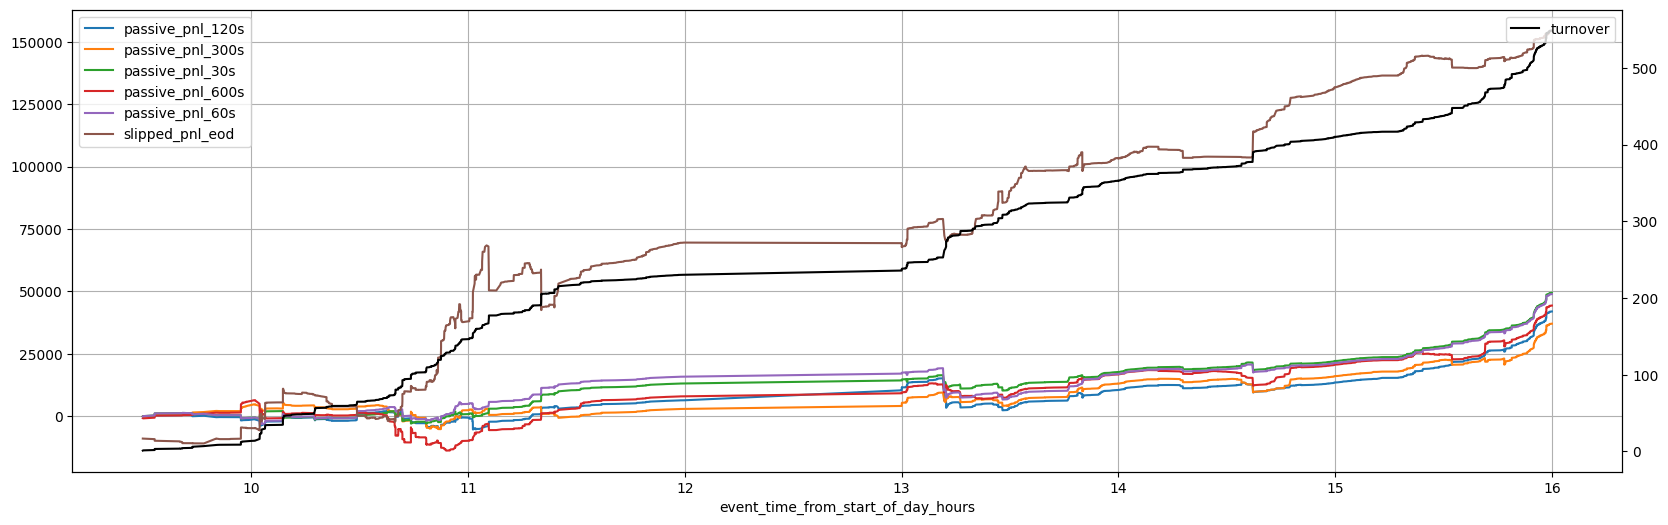

In [40]:
iDisp.display(HTML("<H3>Quote - Optiver PnL by Time of Day</H3>"))

plot(trade_data, index='event_time_from_start_of_day_hours', values=['passive_pnl_30s', 'passive_pnl_60s', 'passive_pnl_120s', 'passive_pnl_300s', 'passive_pnl_600s', 'slipped_pnl_eod'], values_right='turnover', 
     filters=(lambda x: (x['broker_name'] == 'Optiver Trading Hong Kong Limited')))

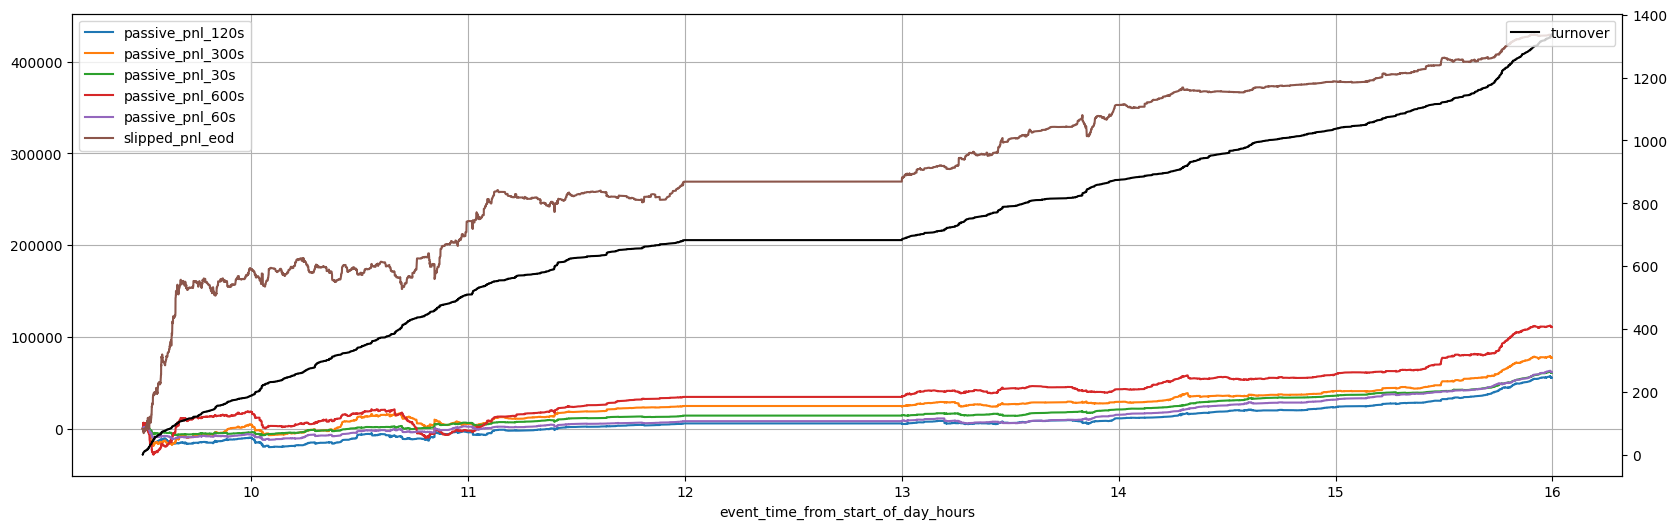

In [41]:
iDisp.display(HTML("<H3>Quote - ABN PnL by Time of Day</H3>"))

plot(trade_data, index='event_time_from_start_of_day_hours', values=['passive_pnl_30s', 'passive_pnl_60s', 'passive_pnl_120s', 'passive_pnl_300s', 'passive_pnl_600s', 'slipped_pnl_eod'], values_right='turnover', 
     filters=(lambda x: (x['broker_name'] == 'ABN AMRO Clearing Hong Kong Limited')))

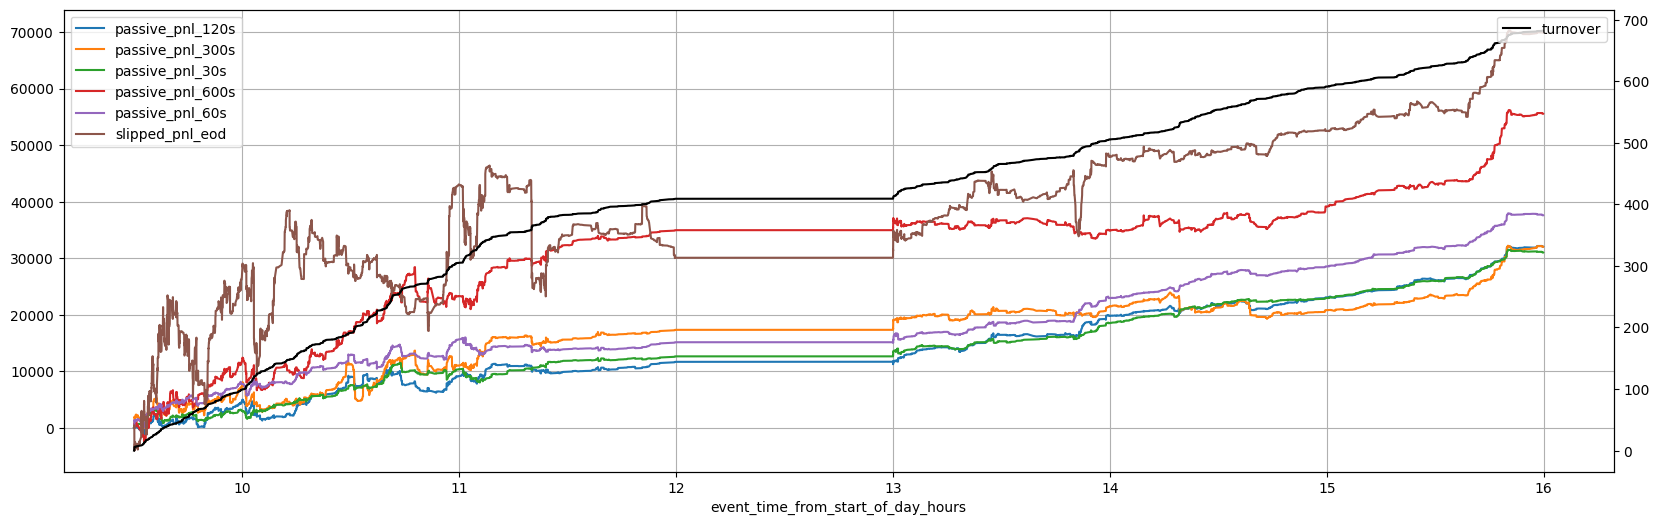

In [42]:
iDisp.display(HTML("<H3>Quote - IMC PnL by Time of Day</H3>"))

plot(trade_data, index='event_time_from_start_of_day_hours', values=['passive_pnl_30s', 'passive_pnl_60s', 'passive_pnl_120s', 'passive_pnl_300s', 'passive_pnl_600s', 'slipped_pnl_eod'], values_right='turnover', 
     filters=(lambda x: (x['broker_name'] == 'IMC Asia Pacific Limited')))

### **HIT ANALYSIS**
- Need to integrate opti orders = how much are we getting rekt
- Then we can also identify how much Barclays, Citadel & other shits are making when they hit us